<a href="https://colab.research.google.com/github/aerjayc/coe197z-hw2/blob/master/mnist_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

!git clone https://github.com/baudm/ee298z.git
!cp ee298z/hw2/mnist_cnn.h5 .
from ee298z.hw2.transforms import corrupt_mnist_copy

!mkdir models

fatal: destination path 'ee298z' already exists and is not an empty directory.
mkdir: cannot create directory ‘models’: File exists


#### Preprocessing

In [0]:
# Import dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Corrupt images
x_train_corrupt = corrupt_mnist_copy(x_train)
x_test_corrupt  = corrupt_mnist_copy(x_test)

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train_corrupt = np.reshape(x_train_corrupt, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test_corrupt = np.reshape(x_test_corrupt, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_train_corrupt = x_train_corrupt.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_test_corrupt = x_test_corrupt.astype('float32') / 255

#### Data Visualization

In [0]:
def show_images(*imgss, figsize=(20,5), cmap='gray', title=None):
    fig, ax = plt.subplots(len(imgss), len(imgss[0]), figsize=figsize)
    for row, imgs in enumerate(imgss):
        for col, img in enumerate(imgs):
            ax[row,col].axis('off')
            ax[row,col].imshow(img, cmap=cmap)
    
    if title:
        plt.suptitle(title)

    plt.show()

    return fig, ax

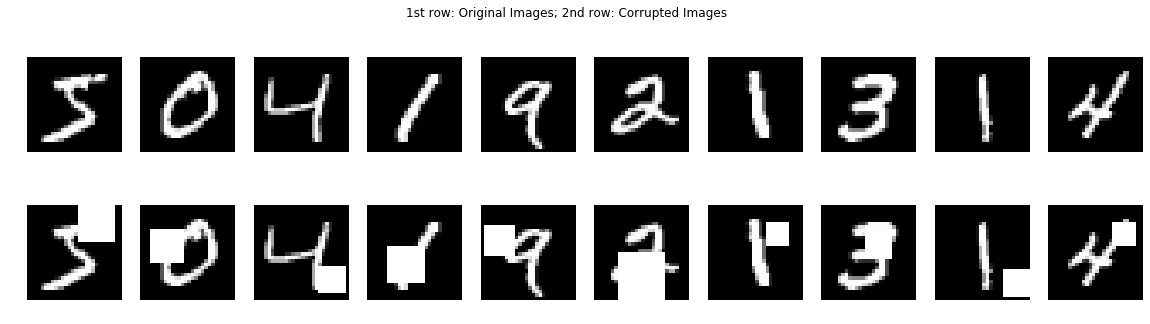

In [33]:
N = 10
original_imgs = x_train[0:N].reshape((N, image_size, image_size)) * 255
corrupted_imgs = x_train_corrupt[0:N].reshape((N, image_size, image_size)) * 255

title = '1st row: Original Images; 2nd row: Corrupted Images'
fig, ax = show_images(original_imgs, corrupted_imgs, title=title)

#### Model

| latent dim | layer_filters | kernel_size | strides | padding | loss function | optimizer | epochs | classifier score | SSIM score | final val_loss |
|-|-|-|-|-|-|-|-|-|-|-|
| 16 | [32, 64] | 3 | 2 | 'same' | mse | adam | 10 | 93.83 | 89.40 |  |
| 16 | [32, 64] | 3 | 2 | 'same' | mse | adam | __20__ | 94.67 | 89.93 |  |
| __32__ | [32, 64] | 3 | 2 | 'same' | mse | adam | 8 | 96.14 | 93.86 | 0.0122 |
| 32 | ~[32, 32, 64]~ | 3 | 1 | 'same' | mse | adam | 5 | 96.96 | 94.94 | 0.0105 |
| 32 | ~[32, 32, 64]~ | 3 | 1 | 'valid' | mse | adam | 5 | 97.01 | 95.22 | 0.0104 |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.04 | 95.15 | 0.0104 |
| 32 | [32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 96.44 | 94.54 | 0.0112 |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.03 | 95.51 | 0.0103 |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.30 | 95.55 | 0.0101 |

In [0]:
from keras import backend as K

def make_autoencoder(input_shape, layer_filters, kernel_size, latent_dim,
                     strides, padding, activation='relu',
                     loss='mse', optimizer='adam'):
    # encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for filters in layer_filters:
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                strides=strides, padding=padding,
                activation=activation)(x)

    # latent vector
    shape = K.int_shape(x)

    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)
    encoder = Model(inputs, latent, name='encoder')

    # decoder
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                            strides=strides, padding=padding,
                            activation=activation)(x)
    
    outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size,
                              padding='same', activation='sigmoid',
                              name='decoder_output')(x)

    decoder = Model(latent_inputs, outputs, name='decoder')


    autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
    autoencoder.compile(loss=loss, optimizer=optimizer)

    return autoencoder


from keras.utils import plot_model
import matplotlib.image as mpimg

def plot_model_summary(model, to_file='model.png', figsize=(20,20), dpi=150,
                       show_shapes=True, show_layer_names=True, expand_nested=True):
    plot_model(model, to_file=to_file, show_shapes=show_shapes, dpi=dpi,
               show_layer_names=show_layer_names, expand_nested=expand_nested)

    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(mpimg.imread(to_file))
    plt.show()

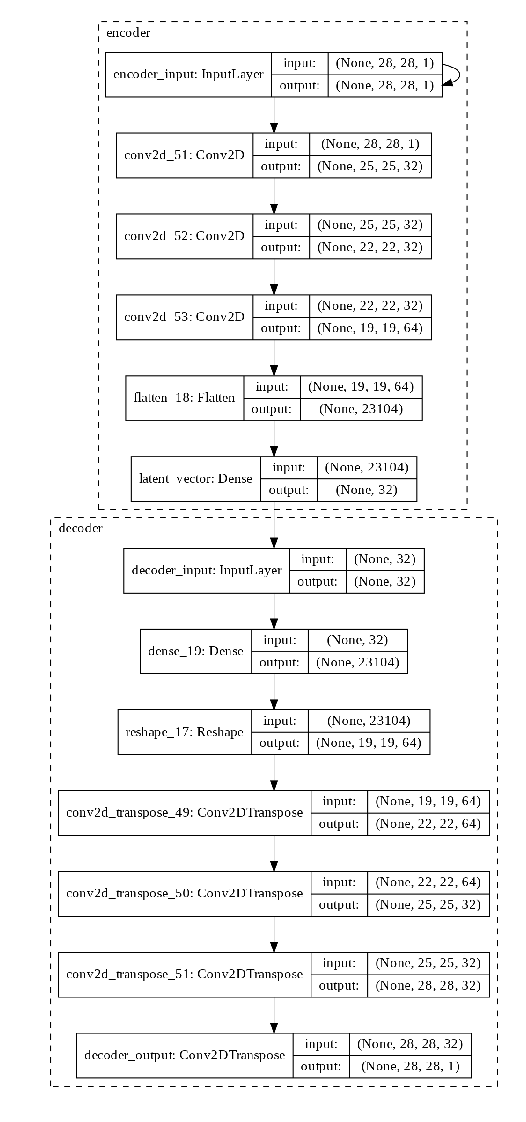

In [57]:
# network parameters
input_shape = x_train.shape[1:] # (28,28,1)
batch_size = 32
kernel_size = 4
latent_dim = 32
strides = 1
padding = 'valid'

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 32, 64]

loss = 'mse'
optimizer = 'adam'

autoencoder = make_autoencoder(input_shape, layer_filters, kernel_size, latent_dim,
                               strides, padding, loss=loss, optimizer=optimizer)
plot_model_summary(autoencoder, to_file='autoencoder.png')

#### training

In [58]:
# train the autoencoder

earlystopping = EarlyStopping(min_delta=0.0001, verbose=1,
                              restore_best_weights=True, patience=0)

history = autoencoder.fit(x_train_corrupt,
                          x_train,
                          validation_data=(x_test_corrupt, x_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 54s 908us/step - loss: 0.0258 - val_loss: 0.0135
Epoch 2/10
60000/60000 [==============================] - 43s 720us/step - loss: 0.0121 - val_loss: 0.0113
Epoch 3/10
60000/60000 [==============================] - 44s 734us/step - loss: 0.0107 - val_loss: 0.0106
Epoch 4/10
60000/60000 [==============================] - 46s 762us/step - loss: 0.0098 - val_loss: 0.0105
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


In [0]:
def plot_losses(history, skip_init=0):
    loss = history.history['loss'][skip_init:]
    val_loss = history.history['val_loss'][skip_init:]

    plt.figure()
    plt.plot(range(1,len(loss)+1), loss, label='train loss')
    plt.plot(range(1,len(loss)+1), val_loss, label='validation loss')

    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('Mean Square Error')
    plt.xlim(left=0)
    plt.legend()

    plt.show()

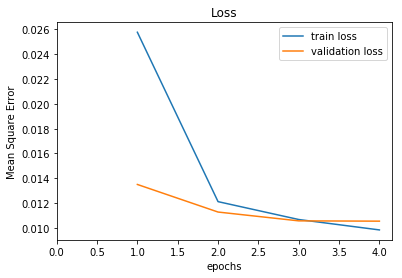

In [60]:
plot_losses(history)

#### Predictions

In [0]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_corrupt)

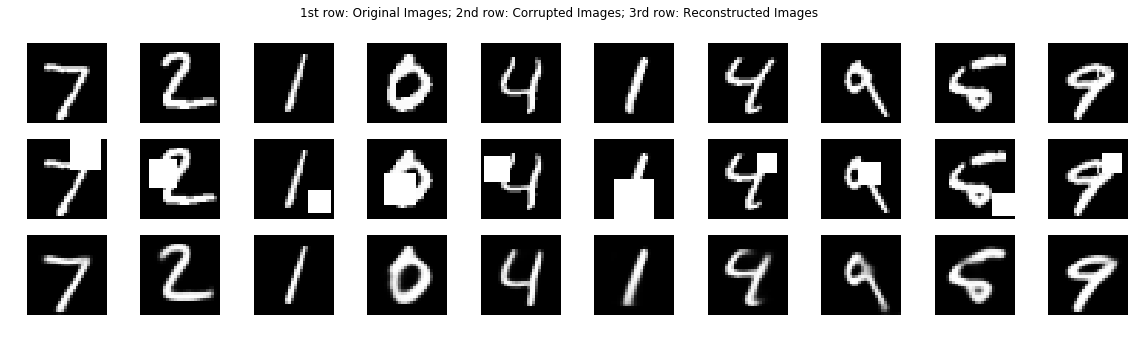

In [62]:
N = 10
original_imgs = x_test[0:N].reshape((N, image_size, image_size))
corrupted_imgs = x_test_corrupt[0:N].reshape((N, image_size, image_size))
reconstructed_imgs = x_decoded[0:N].reshape((N, image_size, image_size))

title = '1st row: Original Images; 2nd row: Corrupted Images; 3rd row: Reconstructed Images'
fig, ax = show_images(original_imgs,
                      corrupted_imgs,
                      reconstructed_imgs,
                      title=title)

In [63]:
from ee298z.hw2.benchmark_keras import test_model

test_model(autoencoder, x_test.reshape(-1,28,28), y_test, batch_size=100)

Classifier score: 96.72
SSIM score: 95.04
